In [40]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import git

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
import einops

from torch.utils.data import RandomSampler, WeightedRandomSampler, DataLoader
from torchdata.datapipes.map import SequenceWrapper

from gfn_attractors.misc import image_utils as iu
from image_datamodule import ImageDataModule

In [145]:
class ContinuousDSpritesDataModule(ImageDataModule):

    RAW_DATA_PATH = os.path.join(git.Repo('.', search_parent_directories=True).working_tree_dir, 
                                 'data/raw/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

    COLORS = np.array([
        (1, 1, 1), # white
        (1, 0, 0), # red
        (0, 1, 0), # green
        (0, 0, 1), # blue
        (1, 1, 0), # yellow
        (1, 0, 1), # magenta
        (0, 1, 1), # cyan
    ])

    COLOR_NAMES = np.array([
        'white',
        'red',
        'green',
        'blue',
        'yellow',
        'magenta',
        'cyan',
    ])

    LABEL_SENTENCE_FEATURES = ['color', 'obj_shape', 'scale', 'x', 'y']
    POSITION_WEIGHTS = np.array([2, 3, 4, 5, 4, 3, 2, 1, 
                                 2, 3, 4, 5, 4, 3, 2, 1, 
                                 2, 3, 4, 5, 4, 3, 2, 1, 
                                 2, 3, 4, 5, 4, 3, 2])
    rgb = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1],
                    [1, 1, 0],
                    [1, 0, 1],
                    [0, 1, 1],
                    [1, 1, 1]], dtype=float)

    def __init__(self, 
                 size=64,
                 constant_orientation=True,
                 min_scale=0,
                 f_validation=.1,
                 holdout_xy_mode=False,
                 holdout_xy_nonmode=False,
                 holdout_xy_shape=False,
                 holdout_xy_mode_color=False,
                 holdout_shape_color=False,
                 **kwargs):
        """
        num_pos_tokens: if not None, label sentences are included in the dataloaders
        holdout_xy_mode: if True, hold out all data in (1, 2) region
        holdout_xy_nonmode: if True, hold out all data from a single position in (2, 1) region
        holdout_xy_shape: if True, hold out all squares in (3, 0) region
        holdout_xy_mode_color: if True, hold out all yellow objects in (0, 3) region
        holdout_shape_color: if True, holdout all magenta ovals
        """
        super().__init__(**kwargs)
        self._size = size
        self.constant_orientation = constant_orientation
        self.min_scale = min_scale
        self.f_validation = f_validation
        self.holdout_xy_mode = holdout_xy_mode
        self.holdout_xy_nonmode = holdout_xy_nonmode
        self.holdout_xy_shape = holdout_xy_shape
        self.holdout_xy_mode_color = holdout_xy_mode_color
        self.holdout_shape_color = holdout_shape_color

    @property
    def num_channels(self):
        return 3

    @classmethod
    def load_raw_data(cls, constant_orientation=True, min_scale=0, size=64):
        with np.load(cls.RAW_DATA_PATH) as raw_data:
            images = raw_data['imgs']
            labels = raw_data['latents_classes']
            latents = raw_data['latents_values']

        if constant_orientation:
            keep = labels[:, 3] == 0
        if min_scale > 0:
            keep &= labels[:, 2] >= min_scale
        
        keep &= labels[:,-1] < 31
        keep &= labels[:,-2] < 31
        images = images[keep]
        labels = labels[keep][:, [1, 2, 4, 5]]
        latents = latents[keep][:, [1, 2, 4, 5]]

        if size != 64:
            images = transforms.Resize(size)(torch.tensor(images)).numpy()
        return images, labels, latents
    
    def prepare_data(self):
        self.images, self.labels, self.latents = self.load_raw_data(self.constant_orientation, self.min_scale, self._size)
        self.split_dataset()
        sample_weights = self.POSITION_WEIGHTS[self.labels[:,-2]] * self.POSITION_WEIGHTS[self.labels[:,-1]]
        sample_weights[self.valid_indices] = 0
        self.sample_weights = sample_weights / sample_weights.sum()

    def split_dataset(self):
        self.train_colors = torch.ones((len(self), 7), dtype=bool)
        self.test_colors = torch.ones((len(self), 7), dtype=bool)

        # Hold out all data in (1, 2) region
        xy_mode_keep = self.labels[:,2] >= 8
        xy_mode_keep &= self.labels[:,2] < 16
        xy_mode_keep &= self.labels[:,3] >= 16
        xy_mode_keep &= self.labels[:,3] < 24
        self.test_xy_mode_indices = torch.arange(len(self))[xy_mode_keep]

        # Hold out all data from a single position in (2, 1) region
        xy_nonmode_keep = self.labels[:,2] == 21 
        xy_nonmode_keep &= self.labels[:,3] == 9
        self.test_xy_nonmode_indices = torch.arange(len(self))[xy_nonmode_keep]

        # Hold out all squares in (3, 0) region
        xy_shape_keep = self.labels[:,0] == 0
        xy_shape_keep &= self.labels[:,2] >= 24
        xy_shape_keep &= self.labels[:,3] < 8
        self.test_xy_shape_indices = torch.arange(len(self))[xy_shape_keep]

        # Hold out all yellow objects in (0, 3) region
        # self.test_xy_mode_colors = torch.zeros((len(self), 7), dtype=bool)
        if self.holdout_xy_mode_color:
            xy_mode_keep = self.labels[:,2] < 8
            xy_mode_keep &= self.labels[:,3] >= 24
            self.test_xy_mode_color_indices = torch.arange(len(self))[xy_mode_keep]
            self.train_colors[xy_mode_keep, 3] = 0
            self.test_colors[xy_mode_keep] = 0

        # Holdout all magenta ovals
        if self.holdout_shape_color:
            shape_color_keep = self.labels[:,0] == 1
            self.test_shape_color_indices = torch.arange(len(self))[shape_color_keep]
            self.train_colors[shape_color_keep, 4] = 0
            self.test_colors[shape_color_keep] = 0

        if self.holdout_xy_mode_color:
            self.test_colors[xy_mode_keep, 3] = 1
        if self.holdout_shape_color:
            self.test_colors[shape_color_keep, 4] = 1

        # Train and valid indices
        train_keep = torch.ones(len(self), dtype=bool)
        if self.holdout_xy_mode:
            train_keep[self.test_xy_mode_indices] = 0
        if self.holdout_xy_nonmode:
            train_keep[self.test_xy_nonmode_indices] = 0
        if self.holdout_xy_shape:
            train_keep[self.test_xy_shape_indices] = 0

        self.test_indices = torch.arange(len(self))[~train_keep]
        nontest_indices = torch.arange(len(self))[train_keep]
        generator = torch.Generator().manual_seed(self.seed)
        train_indices, valid_indices = random_split(range(len(nontest_indices)), [1-self.f_validation, self.f_validation], generator=generator)
        self.train_indices = torch.tensor(nontest_indices[train_indices.indices])
        self.valid_indices = torch.tensor(nontest_indices[valid_indices.indices])
        
        
    def create_batch(self, indices, test_set=False):
        batch_images = self.images[indices]
        batch_images = einops.repeat(batch_images, 'b x y -> b 3 x y')
        batch_latents = self.latents[indices]
        batch_labels = self.labels[indices]

        color_indices = self.test_colors[indices] if test_set else self.train_colors[indices]
        color_indices = torch.distributions.Categorical(color_indices.float()).sample()
        color_modes = self.rgb[color_indices]
        noise = torch.distributions.HalfNormal(.2).sample((len(batch_images), 3)).numpy()
        colors = color_modes + noise * (-2*color_modes + 1)
        batch_latents = np.concatenate([colors, batch_latents], axis=1)
        batch_labels = np.concatenate([color_modes, batch_labels], axis=1)
        colors = einops.repeat(colors, 'b c -> b c 1 1')
        batch_images = batch_images * colors

        return {'index': torch.tensor(indices), 
                'image': torch.tensor(batch_images).float(), 
                'label': torch.tensor(batch_labels).float(),
                'latent': torch.tensor(batch_latents).float()}
    
    def train_dataloader(self, batch_size=None) -> DataLoader:
        sampler = WeightedRandomSampler(self.sample_weights, len(self.sample_weights))
        batch_size = self.batch_size if batch_size is None else batch_size
        return DataLoader(self, batch_size=batch_size, sampler=sampler, collate_fn=lambda x: x, 
                          drop_last=True)
    
    def valid_dataloader(self, batch_size=None) -> DataLoader:
        sampler = RandomSampler2(self.valid_indices, replacement=False)
        batch_size = self.batch_size if batch_size is None else batch_size
        return DataLoader(self, batch_size=batch_size, sampler=sampler, collate_fn=lambda x: x, drop_last=True)
    
    def __getitem__(self, index):
        return {k: v[0] for k, v in self.__getitems__([index]).items()}

    def __getitems__(self, indices):
        if isinstance(indices, torch.Tensor):
            indices = indices.tolist()
        return self.create_batch(indices)
        # batch_images, batch_latents = self.create_batch(indices)
        # return {'index': torch.tensor(indices), 'image': batch_images, 'latent': batch_latents}

In [146]:
data_module = ContinuousDSpritesDataModule(size=32,
                                           holdout_xy_mode=True,
                                           holdout_xy_nonmode=True,
                                           holdout_xy_shape=True,
                                           holdout_xy_mode_color=True,
                                           holdout_shape_color=True)
data_module.prepare_data()

/home/ajhnam/anaconda3/envs/gfn-attractors/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_344438/4216459168.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ind

In [158]:
dataloader = data_module.train_dataloader()
for batch in dataloader:
    print(batch['image'].shape)
    print(batch['label'].shape)
    print(batch['latent'].shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 7])
torch.Size([128, 7])


/tmp/ipykernel_344438/4216459168.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'index': torch.tensor(indices),


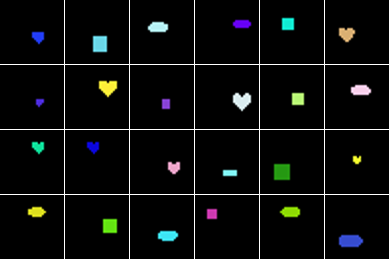

In [147]:
# indices = np.random.choice(len(data_module.test_xy_mode_indices), 24)
indices = np.random.choice(len(data_module.train_indices), 24)
indices = data_module.train_indices[indices]
batch = data_module.create_batch(indices, test_set=False)
images = batch['image']
iu.compose_grid([data_module.render(images[i], size=64) for i in range(24)], rows=4)

/tmp/ipykernel_344438/4216459168.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'index': torch.tensor(indices),


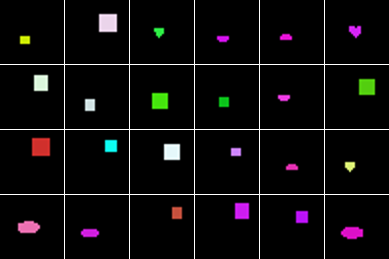

In [157]:
# test_indices = data_module.test_xy_mode_indices
# test_indices = data_module.test_xy_nonmode_indices
# test_indices = data_module.test_xy_shape_indices
# test_indices = data_module.test_xy_mode_color_indices
# test_indices = data_module.test_shape_color_indices
test_indices = data_module.test_indices
indices = np.random.choice(len(test_indices), 24)
indices = test_indices[indices]
batch = data_module.create_batch(indices, test_set=True)
images = batch['image']
iu.compose_grid([data_module.render(images[i], size=64) for i in range(24)], rows=4)

In [130]:
batch['label']

tensor([[ 1.,  1.,  1.,  2.,  3., 15., 23.],
        [ 1.,  0.,  1.,  1.,  4., 15., 23.],
        [ 1.,  0.,  1.,  1.,  2.,  8., 17.],
        [ 1.,  0.,  1.,  1.,  4.,  9., 23.],
        [ 1.,  0.,  1.,  1.,  1., 13., 17.],
        [ 1.,  1.,  0.,  2.,  1., 14., 22.],
        [ 1.,  0.,  1.,  2.,  5., 15., 16.],
        [ 0.,  1.,  1.,  0.,  5.,  8., 16.],
        [ 1.,  0.,  1.,  1.,  5., 10., 19.],
        [ 1.,  0.,  1.,  1.,  2., 14., 21.],
        [ 1.,  0.,  1.,  1.,  1., 10., 17.],
        [ 1.,  0.,  1.,  1.,  2.,  8., 17.],
        [ 0.,  1.,  0.,  0.,  1., 14., 18.],
        [ 0.,  0.,  1.,  2.,  3., 10., 21.],
        [ 1.,  1.,  0.,  0.,  0., 14., 19.],
        [ 1.,  1.,  1.,  0.,  5., 14., 23.],
        [ 0.,  1.,  0.,  0.,  4., 10., 16.],
        [ 1.,  0.,  0.,  0.,  2.,  8., 21.],
        [ 0.,  1.,  1.,  0.,  3., 15., 16.],
        [ 1.,  1.,  1.,  0.,  3., 11., 22.],
        [ 0.,  1.,  0.,  0.,  4.,  9., 23.],
        [ 1.,  0.,  1.,  1.,  1., 14., 23.],
        [ 

In [96]:
latents = batch['label']
latents

tensor([[ 0.,  1.,  0.,  1.,  3., 24.,  2.],
        [ 0.,  0.,  1.,  0.,  1., 16., 12.],
        [ 1.,  1.,  1.,  0.,  0., 17., 25.],
        [ 0.,  0.,  1.,  0.,  0.,  7., 13.],
        [ 1.,  1.,  1.,  0.,  3., 25., 28.],
        [ 1.,  1.,  0.,  1.,  3., 30.,  1.],
        [ 1.,  0.,  0.,  1.,  1., 22., 10.],
        [ 1.,  0.,  0.,  0.,  0., 19., 17.],
        [ 0.,  1.,  1.,  0.,  2.,  2., 18.],
        [ 0.,  1.,  1.,  0.,  3., 29., 10.],
        [ 1.,  1.,  0.,  0.,  4.,  6., 17.],
        [ 0.,  0.,  1.,  0.,  2.,  2.,  8.],
        [ 1.,  1.,  0.,  1.,  2., 11.,  7.],
        [ 1.,  0.,  0.,  1.,  1., 27., 14.],
        [ 1.,  0.,  0.,  1.,  2.,  3., 26.],
        [ 0.,  1.,  0.,  0.,  3., 30., 30.],
        [ 1.,  1.,  0.,  1.,  3., 12., 14.],
        [ 1.,  1.,  0.,  0.,  4., 11.,  4.],
        [ 0.,  0.,  1.,  0.,  5., 30., 24.],
        [ 0.,  0.,  1.,  1.,  2., 17., 27.],
        [ 0.,  1.,  1.,  0.,  2.,  6., 15.],
        [ 1.,  1.,  1.,  0.,  2.,  0.,  6.],
        [ 

In [57]:
keep = data_module.labels[:,2] >= 8
keep &= data_module.labels[:,2] < 16
keep &= data_module.labels[:,3] >= 16
keep &= data_module.labels[:,3] < 24
test_position_mode_indices = torch.arange(len(keep))[keep]
test_position_mode_indices

tensor([  264,   265,   266,  ..., 16823, 16824, 16825])

In [16]:
keep = data_module.labels[:,2] == 21 
keep &= data_module.labels[:,3] == 9
test_position_indices = torch.arange(len(keep))[keep]
test_position_indices

tensor([  676,  1637,  2598,  3559,  4520,  5481,  6442,  7403,  8364,  9325,
        10286, 11247, 12208, 13169, 14130, 15091, 16052, 17013])

In [25]:
color_modes = np.ones((len(data_module), 7), dtype=bool)

In [29]:
keep = data_module.labels[:,2] < 8
keep &= data_module.labels[:,3] >= 24
color_modes[keep, 3] = 0

keep = data_module.labels[:,0] == 1
color_modes[keep, 4] = 0

(array([   24,    25,    26, ..., 16582, 16583, 16584]),)

In [232]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from torchdata.datapipes.map import SequenceWrapper

# sampler = WeightedRandomSampler(data_module.sample_weights, len(data_module.sample_weights))
sampler = WeightedRandomSampler(data_module.sample_weights, len(data_module.sample_weights))
i = 0
for batch in DataLoader(data_module, batch_size=32, sampler=sampler, collate_fn=lambda x: x):
    i += 1
i
# dp = SequenceWrapper(self.test_indices)
# dp = dp.map(lambda i: self[i])
# batch_size = self.batch_size if batch_size is None else batch_size
# dataloader = DataLoader(data_module, batch_size=32, sampler=sampler)


361

In [234]:
sampler = RandomSampler(data_module.valid_indices, num_samples=len(data_module.valid_indices), replacement=True)
dataloader = DataLoader(data_module, batch_size=32, sampler=sampler, collate_fn=lambda x: x, drop_last=True)
i = 0
for batch in DataLoader(data_module, batch_size=32, sampler=sampler, collate_fn=lambda x: x):
    i += 1
i

37

In [235]:
data_module.valid_indices.shape

torch.Size([1153])

In [178]:
indices, images, latents = data_module.sample_training_batch(10)

In [179]:
images.shape

torch.Size([10, 3, 32, 32])

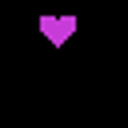

In [180]:
data_module.render(images[3], size=128)

In [163]:
n = 50
indices = np.random.choice(range(len(data_module.images)), size=n, p=data_module.sample_weights, replace=False)
batch_images, batch_latents = data_module.create_batch(indices)

In [160]:
batch_images.float()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [155]:
batch_images

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [150]:
batch_latents

array([[0.06010244, 0.95630283, 0.91258153, 1.        , 0.7       ,
        0.25806452, 0.80645161],
       [0.85552903, 0.75694844, 0.03935844, 3.        , 0.6       ,
        0.93548387, 0.25806452],
       [0.84945388, 0.63862604, 0.05785464, 1.        , 0.5       ,
        0.61290323, 0.64516129],
       [0.15421729, 0.33562714, 0.87293886, 1.        , 0.5       ,
        0.38709677, 0.48387097],
       [0.97584515, 0.09746098, 0.16778789, 2.        , 0.7       ,
        0.38709677, 0.77419355],
       [0.38210371, 0.71260872, 0.3835009 , 3.        , 0.8       ,
        0.64516129, 0.90322581],
       [0.15711698, 0.15440336, 0.81402144, 3.        , 0.6       ,
        0.35483871, 0.64516129],
       [0.95789881, 0.44397765, 0.14686003, 3.        , 0.8       ,
        0.19354839, 0.38709677],
       [0.73000613, 0.60885853, 0.73825973, 2.        , 0.6       ,
        0.64516129, 0.77419355],
       [0.45742446, 0.64921159, 0.33923173, 1.        , 1.        ,
        0.35483871, 0.3

In [129]:
constant_orientation = True
min_scale = 0
size = 32

with np.load(AmbiguousDSpritesDataModule.RAW_DATA_PATH) as raw_data:
    images = raw_data['imgs']
    labels = raw_data['latents_classes']
    latents = raw_data['latents_values']

if constant_orientation:
    # Remove all the images with orientation != 0
    keep = labels[:, 3] == 0
if min_scale > 0:
    keep &= labels[:, 2] >= min_scale
keep &= labels[:,-1] < 31
keep &= labels[:,-2] < 31
images = images[keep]
labels = labels[keep][:, [1, 2, 4, 5]]
latents = latents[keep][:, [1, 2, 4, 5]]

if size != 64:
    images = transforms.Resize(size)(torch.tensor(images)).numpy()

/home/ajhnam/anaconda3/envs/gfn-attractors/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [138]:
batch_size = 10
pos_weight = np.array([2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2])
weight = pos_weight[labels[:,-2]] * pos_weight[labels[:,-1]]
weight = weight / weight.sum()

indices = np.random.choice(range(len(images)), size=batch_size, p=weight, replace=False)
batch_images = images[indices]
batch_images = einops.repeat(batch_images, 'b x y -> b 3 x y')
batch_latents = latents[indices]

In [139]:
rgb = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1],
               [1, 1, 0],
               [1, 0, 1],
               [0, 1, 1],
               [1, 1, 1]], dtype=float)
colors = rgb[np.random.randint(0, len(rgb), batch_size)]
noise = x = torch.distributions.HalfNormal(.2).sample((batch_size, 3)).numpy()
colors += noise * (-2*colors + 1)
batch_latents = np.concatenate([colors, batch_latents], axis=1)
colors = einops.repeat(colors, 'b c -> b c 1 1')
batch_images = batch_images * colors

In [140]:
batch_latents

array([[0.09240376, 0.78590433, 0.00472882, 1.        , 0.8       ,
        0.22580645, 0.03225806],
       [0.89358191, 0.88853043, 0.04821232, 2.        , 0.5       ,
        0.93548387, 0.03225806],
       [0.93807215, 0.13481329, 0.08933251, 3.        , 0.7       ,
        0.29032258, 0.96774194],
       [0.96036996, 0.21384671, 0.81938758, 1.        , 0.8       ,
        0.83870968, 0.22580645],
       [0.27016112, 0.49734187, 0.32005247, 3.        , 1.        ,
        0.93548387, 0.09677419],
       [0.01653031, 0.85030366, 0.98511193, 2.        , 0.6       ,
        0.32258065, 0.77419355],
       [0.07797339, 0.92051079, 0.99402194, 1.        , 0.8       ,
        0.58064516, 0.87096774],
       [0.71592164, 0.29553682, 0.13806298, 3.        , 0.5       ,
        0.25806452, 0.64516129],
       [0.93004499, 0.81124002, 0.31756613, 3.        , 0.5       ,
        0.09677419, 0.64516129],
       [0.04546512, 0.99299737, 0.77421126, 2.        , 0.7       ,
        0.03225806, 0.1

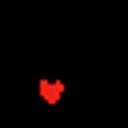

In [141]:
data_module.render(torch.tensor(batch_images)[2], size=128)

(array([20., 26., 23., 27., 18., 17., 31., 20., 23., 19., 21., 12., 21.,
        23., 14., 14., 18., 18., 20., 12.,  7., 12., 11., 10.,  8.,  5.,
         2.,  9.,  5.,  4.,  4.,  2.,  4.,  2.,  4.,  4.,  2.,  1.,  2.,
         4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  6.,  1.,  0.,
         4.,  4.,  1.,  4.,  4.,  2.,  8.,  5.,  4.,  9., 15.,  9., 18.,
         7., 12.,  9., 14.,  6., 20., 19.,  8., 12., 27., 23., 17., 20.,
        22., 17., 19., 27., 27., 21., 27., 25., 21.]),
 array([0.00147911, 0.011462  , 0.0214449 , 0.03142779, 0.04141069,
        0.05139358, 0.06137647, 0.07135937, 0.08134226, 0.09132515,
        0.10130805, 0.11129094, 0.12127384, 0.13125673, 0.14123962,
        0.15122252, 0.16120541, 0.1711883 , 0.1811712 , 0.19115409,
        0.20113699, 0.21111988, 0.22110277, 0.23108567, 0.24106856,
        0.25105145, 0.26103435, 0.27101724, 0.28100014, 0.29098303,
        0.30096592, 0.3109

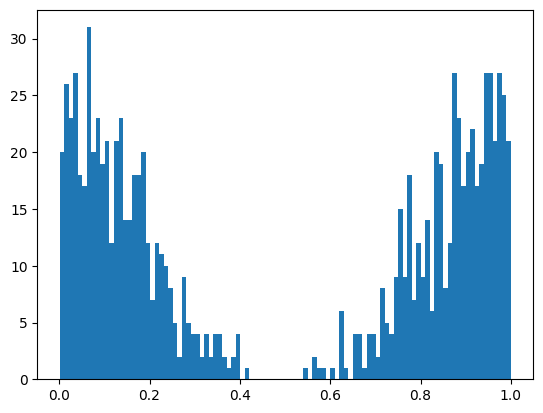

In [46]:
from matplotlib import pyplot as plt
plt.hist((np.random.beta(4, 4, size=(1000, 1)) + .5)%1, bins=100)
# plt.h (np.random.beta(5, 5, size=(100, 1)) + .5)%1

In [39]:
batch_images = images[indices]

(10,)

(array([24., 26., 31., 33., 21., 30., 34., 24., 24., 36., 24., 24., 21.,
        22., 32., 17., 21., 28., 34., 18., 24., 22., 24., 24., 15., 15.,
        21., 17., 15., 19.,  8., 22., 15., 12., 10.,  8., 16., 10., 12.,
        13., 16., 15.,  8.,  6.,  7.,  9.,  9.,  5.,  3.,  5.,  6.,  2.,
         6.,  6.,  7.,  9.,  1.,  3.,  3.,  0.,  1.,  4.,  2.,  1.,  0.,
         2.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  3.,  0.,  0.,  2.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00101205, 0.00812837, 0.01524468, 0.022361  , 0.02947732,
        0.03659363, 0.04370994, 0.05082626, 0.05794258, 0.06505889,
        0.07217521, 0.07929152, 0.08640784, 0.09352416, 0.10064047,
        0.10775679, 0.1148731 , 0.12198942, 0.12910573, 0.13622205,
        0.14333837, 0.15045469, 0.157571  , 0.16468732, 0.17180362,
        0.17891994, 0.18603626, 0.19315258, 0.20026889, 0.20738521,
        0.21450153, 0.2216

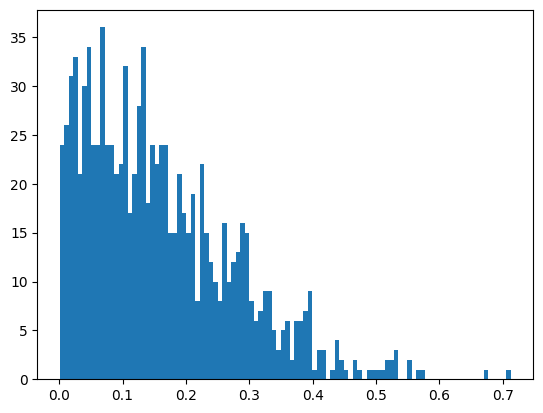

In [105]:
x = torch.distributions.HalfNormal(.2).sample((1000, )).numpy()
plt.hist(x, bins=100)